In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

2023-08-16 12:58:52.430190: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/tensorrt/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/usr/local/cuda-11.2/lib64:
2023-08-16 12:58:52.430223: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [5]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [6]:
stock = 'GOOG' # 'GOOG', 'INTC'

In [7]:
if stock == 'GOOG':
    ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)
elif stock == 'INTC':
    ckpt_path = '../checkpoints/pleasant-cherry-152_i6h5n74c/' # 0.5 y INTC, (full model)

In [8]:
ckpt_path

'../checkpoints/treasured-leaf-149_84yhvzjt/'

In [9]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=4, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [10]:
# scale down to single GPU, single sample inference
args.bsz = 1 #1, 10
args.num_devices = 1

batchnorm = args.batchnorm

In [11]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [12]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [13]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [14]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [15]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [16]:
# entire test set after training data

if stock == 'GOOG':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/GOOG/'
elif stock == 'INTC':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/INTC/'

msg_files = sorted(glob(str(data_dir) + '/*message*.npy'))
book_files = sorted(glob(str(data_dir) + '/*book*.npy'))

ds = LOBSTER_Dataset(
    msg_files,
    n_messages=n_messages + n_eval_messages,
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    seed=42,
    n_cache_files=100,
    randomize_offset=False,
    book_files=book_files,
    use_simple_book=True,
    book_transform=False,
    book_depth=500,
    return_raw_msgs=True,
)

In [17]:
data_dir

'/nfs/home/peern/LOBS5/data/test_set/GOOG/'

In [18]:
ds.book_files

['/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-14_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-15_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-16_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-19_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-20_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-21_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-22_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-23_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-27_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-28_34200000_57600000_orderbook_10_p

In [19]:
import chex
chex.clear_trace_counter()

In [20]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.WARNING)

In [34]:
results = inference.sample_messages(
    n_samples = 1, # 500
    num_repeats = 1,
    ds = ds,
    rng = rng,
    seq_len = seq_len,
    n_msgs = n_messages,
    n_gen_msgs = n_gen_msgs,
    train_state = state,
    model = model,
    batchnorm = batchnorm,
    encoder = v.ENCODING,
    n_vol_series = n_vol_series,
    sim_book_levels = sim_book_levels,
    sim_queue_len = sim_queue_len,
    data_levels = data_levels,
    save_folder='../data/results/{stock}/inference/'
)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing sample 4538...
ITERATION 0


100%|██████████| 1/1 [09:36<00:00, 576.24s/it]


In [22]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob('./tmp_small/*')
# tmp_files = glob('./tmp/*')

tmp_files = glob(f'../data/results/{stock}/inference/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

### Inference evaluation

In [35]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [41]:
save_folder = f'../data/results/{stock}/losses/'

In [57]:
# calculate sequence losses for test set (for perplexity calculation)

valid_mask_array = valh.syntax_validation_matrix()
v = Vocab()
for sample_i in tqdm(range(len(ds))):
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[sample_i]
    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, ds.book_depth, 100))

    losses = inference.calc_sequence_losses(
        m_seq,  # can be as long as you want --> use first 500 to predict, then calc losses autoregr.
        b_seq,
        state,
        model,
        batchnorm,
        500,  # number of messages in the input sequence
        len(v),
        valid_mask_array
    )

    # save losses to disk
    jnp.save(save_folder + f'/seq_losses_{sample_i}.npy', losses, allow_pickle=True)

  0%|          | 0/42434 [00:00<?, ?it/s]

NameError: name 'valid_mask_array' is not defined

In [42]:
# load sequence losses

loss_files = glob(save_folder + '/*.npy')
print('loading loss data from disk...', save_folder)
losses = []
for f in tqdm(loss_files):
    losses.append(jnp.load(f))
losses = jnp.array(losses)

loading loss data from disk... ../data/results/GOOG/losses/


  0%|          | 0/2072 [00:00<?, ?it/s]

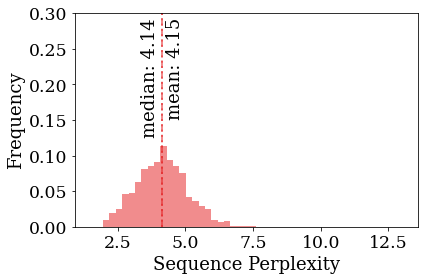

In [25]:
seq_perpl = jnp.exp(losses.mean(axis=(1, 2)))
eval.plot_perplexity_hist(
    seq_perpl,
    min_max=(1.5, 13),
    ylim=(0, 0.3),
    nbins=50
)
plt.savefig(f'../figures/seq_perpl_{stock}.png', dpi=300)

In [44]:
# perplexity per token position --> table
jnp.exp(losses.mean(axis=(0, 1)))

Array([  2.1452491,   1.7127261,   1.0353924,   5.552852 ,   3.1834166,
         1.0019593,   6.214735 , 405.48682  , 770.00806  ,   1.0363657,
         1.4469483,   1.0705057,   1.0073589,   1.625998 ,   2.4061372,
         2.0936184,   1.9338197], dtype=float32)

In [45]:
with onp.printoptions(precision=2, suppress=True):
    print(jnp.exp(losses.mean(axis=(0, 1))))

[  2.15   1.71   1.04   5.55   3.18   1.     6.21 405.49 770.01   1.04
   1.45   1.07   1.01   1.63   2.41   2.09   1.93]


In [46]:
losses.mean()

Array(1.290113, dtype=float32)

In [48]:
# calculate perplexity standard error
eval.calc_bootstrapped_ci(losses.reshape(-1), lambda x: jnp.exp(jnp.mean(x)), rng, ci=0.95, n_bootsrap=100)

(Array(0.00429482, dtype=float32), Array([3.626159, 3.641524], dtype=float32))

In [49]:
jnp.exp(losses.mean())

Array(3.633197, dtype=float32)

[[0.35251    0.5249197  0.09158999]
 [0.3723705  0.5504002  0.10856   ]]


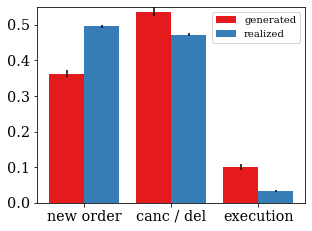

In [29]:
rng, rng_ = jax.random.split(rng)

eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    rng_,
    combine_mod = True
)
# set y axis limit
plt.ylim(0, 0.55)
plt.savefig(f'../figures/event_types_{stock}.png', dpi=300)

In [59]:
min_x = min(results['delta_t_gen'].min(), results['delta_t_eval'].min())
max_x = max(results['delta_t_gen'].max(), results['delta_t_eval'].max())
min_x, max_x
# GOOG: (Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))
# INTC: 

(Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))

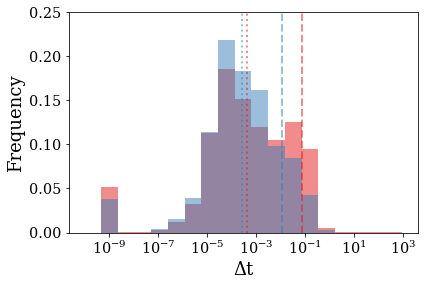

In [61]:
_ = eval.plot_log_hist(results['delta_t_gen'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
_ = eval.plot_log_hist(results['delta_t_eval'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
# set y axis limit
plt.ylim(0, 0.25)
plt.savefig(f'../figures/time_hist_{stock}.png', dpi=300)

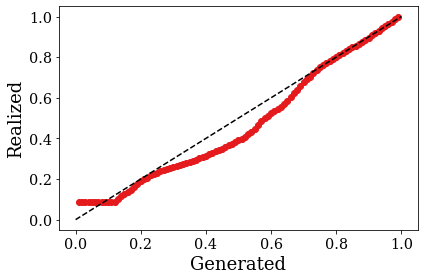

In [284]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)
plt.savefig(f'../figures/time_prob_{stock}.png', dpi=300)

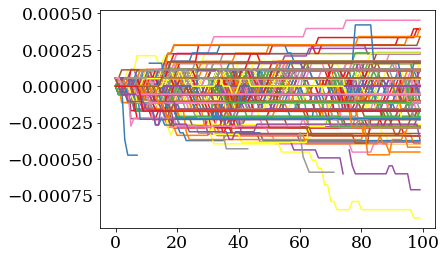

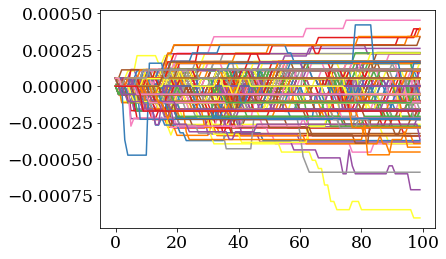

In [51]:
# remove NaNs (temporary empty book side) by forward filling returns

r_gen_df = pd.DataFrame(results['rets_gen'].T)

r_gen_df.plot()
# remove legend from current axis
plt.gca().get_legend().remove()

r_gen_df = r_gen_df.fillna(method='ffill')
r_gen_df.plot()
plt.gca().get_legend().remove()

r_gen = jnp.array(r_gen_df.values).T
r_eval = pd.DataFrame(results['rets_eval'].T).fillna(method='ffill')
r_eval = jnp.array(r_eval.values).T

# remove series starting with NaNs (one empty book side)
r_gen = r_gen[~jnp.isnan(r_eval[:, 0])]  # ... where eval is NaN!
r_eval = r_eval[~jnp.isnan(r_eval[:, 0])]

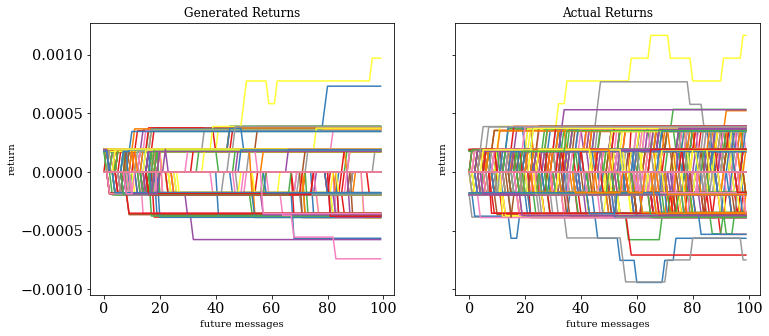

In [286]:
eval.plot_returns(r_gen, r_eval)

In [287]:
results['rets_gen'].shape

(989, 100)

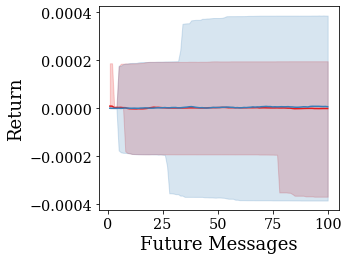

In [288]:
eval.plot_mean_returns(r_gen.T, r_eval.T)
plt.savefig(f'../figures/ret_dist_{stock}.png', dpi=300)

In [73]:
se, percentiles = eval.calc_moments_se(results['rets_gen'], rng)

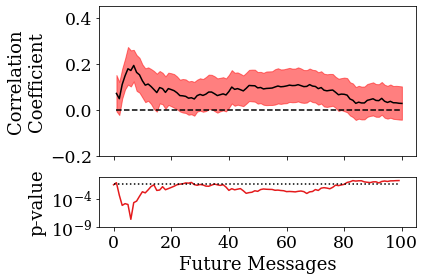

In [52]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(
    r_gen,
    r_eval,
    ci=0.95,
    ylims=((-0.2, 0.45), (1e-9, 1)),
    rng=rng_
)
plt.savefig(f'../figures/corr_{stock}.png', dpi=300)

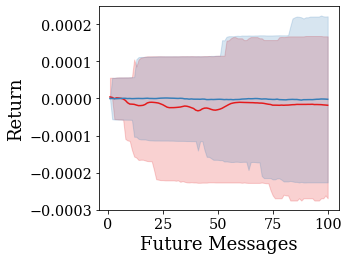

In [240]:
eval.plot_mean_returns(r_gen.T, r_eval.T)

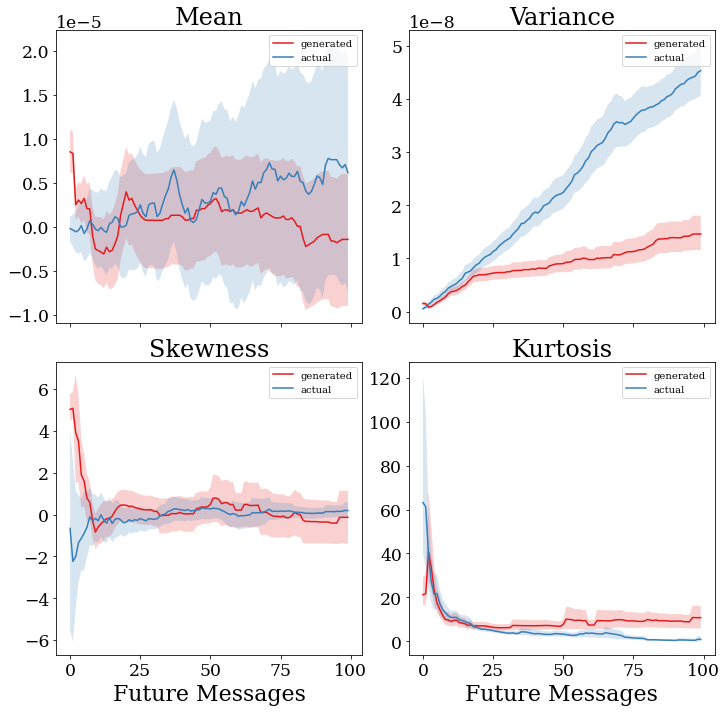

In [290]:
eval.plot_moments(r_gen, r_eval, ci=0.95, rng=rng_)
plt.savefig(f'../figures/moments_{stock}.png', dpi=300)